# Deep Learning for Computer Vision: Exercises
* Group: MH
* Name: Hanh Ngo-Minh
* Studen ID: 1810908

## 1. Environment Setup

### 1.1. Install and import neccessary libraries

In [ ]:
import os
import time
import shutil
import pathlib
import itertools
import random
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

### 1.2. Define environment variables for Kaggle API

In [ ]:
from google.colab import userdata

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

## 2. Data Exploration

### 2.1. Download Dataset

In [ ]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images
!unzip lung-and-colon-cancer-histopathological-images.zip

lung-and-colon-cancer-histopathological-images.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  lung-and-colon-cancer-histopathological-images.zip
replace lung_colon_image_set/colon_image_sets/colon_aca/colonca1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### 2.2. Data Collection

This dataset contains 25,000 histopathological images with 5 classes. All images are 768 x 768 pixels in size and are in jpeg file format.

The images were generated from an original sample of HIPAA compliant and validated sources, consisting of 750 total images of lung tissue (250 benign lung tissue, 250 lung adenocarcinomas, and 250 lung squamous cell carcinomas) and 500 total images of colon tissue (250 benign colon tissue and 250 colon adenocarcinomas) and augmented to 25,000 using the Augmentor package.

There are five classes in the dataset, each with 5,000 images, being:

* Lung benign tissue
* Lung adenocarcinoma
* Lung squamous cell carcinoma
* Colon adenocarcinoma
* Colon benign tissue

### 2.3. Data Structure

In [ ]:
data_path = '/content/lung_colon_image_set'

In [ ]:
def get_data(data_path):
  filepaths = []
  labels = []

  folds = os.listdir(data_path)
  for fold in folds:
    foldpath = os.path.join(data_path, fold)
    flist = os.listdir(foldpath)

    for f in flist:
      f_path = os.path.join(foldpath, f)
      filelist = os.listdir(f_path)

      for file in filelist:
        fpath = os.path.join(f_path, file)
        filepaths.append(fpath)

        if f == 'colon_aca':
          labels.append('Colon Adenocarcinoma')
        elif f == 'colon_n':
          labels.append('Colon Benign Tissue')
        elif f == 'lung_aca':
          labels.append('Lung Adenocarcinoma')
        elif f == 'lung_n':
          labels.append('Lung Benign Tissue')
        elif f == 'lung_scc':
          labels.append('Lung Squamous Cell Carcinoma')
  Fseries = pd.Series(filepaths, name = 'filepaths')
  Lseries = pd.Series(labels, name = 'labels')
  df = pd.concat([Fseries, Lseries], axis = 1)

  return df

In [ ]:
df = get_data(data_path)
df.head(10)

,filepaths,labels
0,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma
1,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma
2,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma
3,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma
4,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma
5,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma
6,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma
7,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma
8,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma
9,/content/lung_colon_image_set/colon_image_sets...,Colon Adenocarcinoma


In [ ]:
df.shape

(25000, 2)

### 2.4. Data Distribution

In [ ]:
def plot_distribution(images_df, palette = None):
  # histogram
  plt.figure(figsize = (16, 4))
  plt.subplot(1, 2, 1)
  if palette:
    sns.set_palette(palette)
  sns.countplot(data = images_df,
                x = 'labels',
                hue = 'labels')
  plt.xticks(rotation = 60)
  # pie chart
  plt.subplot(1, 2, 2)
  plt.pie(x = images_df['labels'].value_counts().values,
          labels = images_df['labels'].value_counts().index,
          autopct = '%1.1f%%')
  plt.suptitle('Distribution of each class in data', size = 20)
  plt.show()

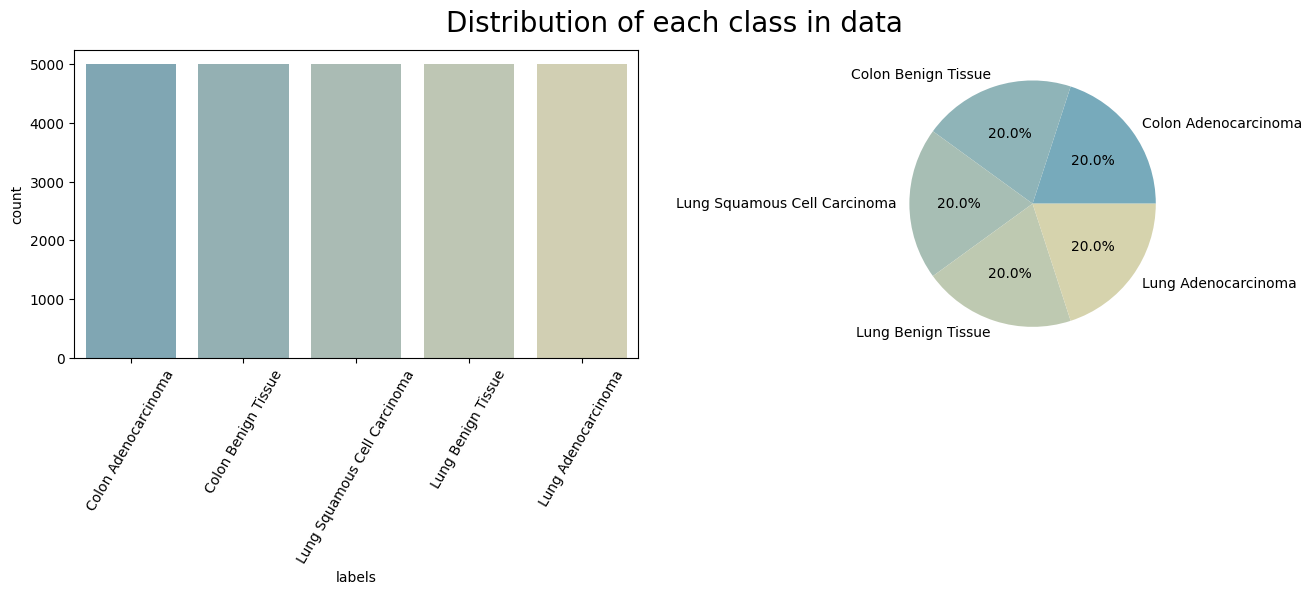

In [ ]:
plot_distribution(df, palette = "blend:#7AB,#EDA")

### 2.5. Split Data

In [ ]:
def split_data(images_df):
  # train set
  strat = images_df['labels']
  train_df, dummy_df = train_test_split(images_df,  train_size = 0.8, shuffle = True, random_state = 42, stratify = strat)

  # valid and test set
  strat = dummy_df['labels']
  valid_df, test_df = train_test_split(dummy_df,  train_size = 0.5, shuffle = True, random_state = 42, stratify = strat)

  return train_df, valid_df, test_df

In [ ]:
def data_generator(train_df, valid_df, test_df):
  batch_size = 64
  img_size = (224, 224)
  channels = 3
  img_shape = (img_size[0], img_size[1], channels)

  tr_gen = ImageDataGenerator()
  # use for both valid and train sets
  ts_gen = ImageDataGenerator()

  train_gen = tr_gen.flow_from_dataframe(train_df, x_col = 'filepaths', y_col = 'labels',
                                         target_size = img_size, class_mode = 'categorical', color_mode = 'rgb',
                                         shuffle = True, batch_size = batch_size)

  valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col = 'filepaths', y_col = 'labels',
                                         target_size = img_size, class_mode = 'categorical', color_mode = 'rgb',
                                         shuffle = True, batch_size = batch_size)

  test_gen = ts_gen.flow_from_dataframe(test_df, x_col = 'filepaths', y_col = 'labels',
                                        target_size = img_size, class_mode = 'categorical', color_mode = 'rgb',
                                        shuffle = False, batch_size = batch_size)

  return train_gen, valid_gen, test_gen

In [ ]:
train_df, valid_df, test_df = split_data(df)
train_gen, valid_gen, test_gen = data_generator(train_df, valid_df, test_df)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


In [ ]:
print(f'Shape of Training Set: {train_df.shape}')
print(f'Shape of Validation Set: {valid_df.shape}')
print(f'Shape of Test Set: {test_df.shape}')

Shape of Training Set: (20000, 2)
Shape of Validation Set: (2500, 2)
Shape of Test Set: (2500, 2)


### 2.6. Data Visualization

In [ ]:
def plot_data(train_gen):
  g_dict = train_gen.class_indices # defines dictionary {'class': index}
  classes = list(g_dict.keys()) # defines list of dictionary's kays (classes), classes names : string
  images, labels = next(train_gen) # get a batch size samples from the generator

  plt.figure(figsize= (16, 16))

  for i in range(16):
      plt.subplot(4, 4, i + 1)
      image = images[i] / 255       # scales data to range (0 - 255)
      plt.imshow(image)
      index = np.argmax(labels[i])  # get image index
      class_name = classes[index]   # get class of image
      plt.title(class_name, color = 'blue', fontsize = 12)
      plt.axis('off')
  plt.show()

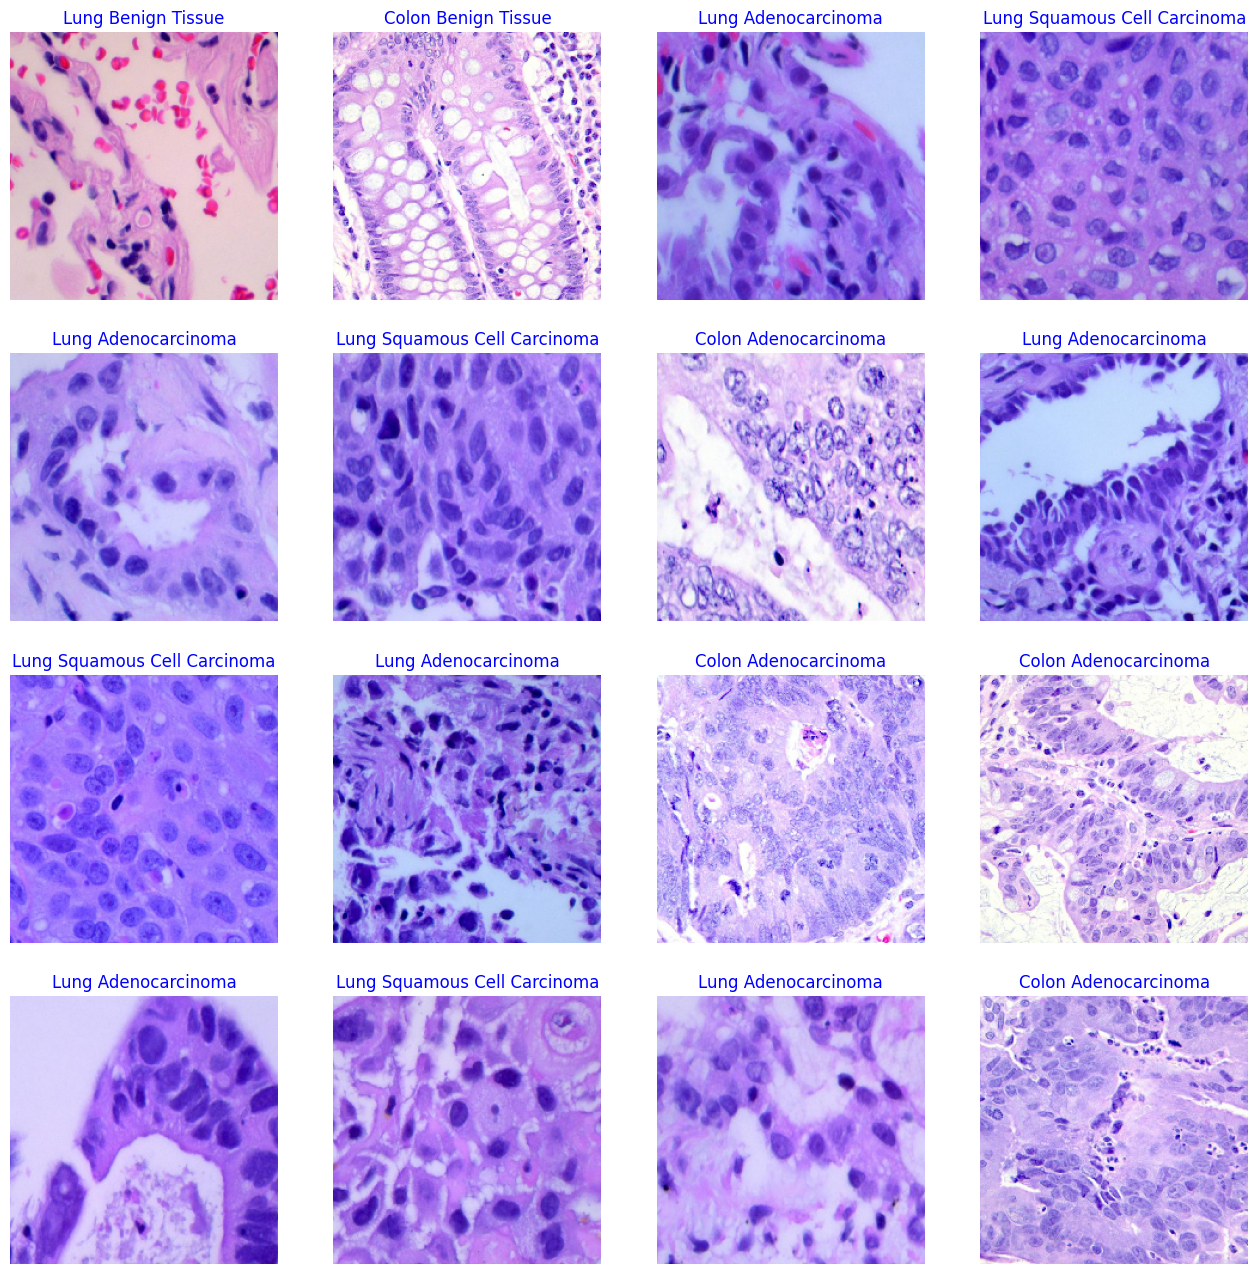

In [ ]:
plot_data(train_gen)

## 3. Transfer Learning

### Helper Functions

In [ ]:
def define_model(model):
  img_shape = (224, 224, 3)
  class_count = 5

  if model == 'EfficientNetB0':
    base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False, weights = "imagenet", input_shape = img_shape, pooling = 'max')
  elif model == 'EfficientNetV2B1':
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(include_top = False, weights = "imagenet", input_shape = img_shape, pooling = 'max')
  elif model == 'ConvNeXtXLarge':
    base_model = tf.keras.applications.ConvNeXtLarge(include_top = False, weights = "imagenet", input_shape = img_shape, pooling = 'max')
  else:
    raise Exception(f'This backbone: {model} has not been supported.')

  for layers in base_model.layers:
    layers.trainable = False

  model = Sequential([
      base_model,
      Dense(256, activation = 'relu'),
      BatchNormalization(),
      Dropout(0.5),
      Dense(class_count, activation = 'softmax')
  ])

  model.compile(Adamax(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

  return model

In [ ]:
def train_model(model, train_gen, valid_gen, epochs):
  early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)

  history = model.fit(x = train_gen,
                      epochs = epochs,
                      verbose = 1,
                      callbacks = [early_stop],
                      validation_data = valid_gen)
  return history

In [ ]:
def get_predictions(model, test_gen):
  preds = model.predict(test_gen, verbose = 1)
  y_pred = np.argmax(preds, axis = 1)
  return y_pred

### 3.1. EfficientNetB0

In [ ]:
model_1 = define_model('EfficientNetB0')
print(model_1.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_10 (Dense)            (None, 256)               327936    
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 4379816 (16.71 MB)
Trainable params: 329

In [ ]:
history_1 = train_model(model_1, train_gen, valid_gen, 15)

Epoch 1/15
313/313 [==============================] - 101s 300ms/step - loss: 0.2350 - accuracy: 0.9177 - val_loss: 0.1149 - val_accuracy: 0.9544
Epoch 2/15
313/313 [==============================] - 90s 289ms/step - loss: 0.1217 - accuracy: 0.9589 - val_loss: 0.0905 - val_accuracy: 0.9692
Epoch 3/15
313/313 [==============================] - 94s 299ms/step - loss: 0.0988 - accuracy: 0.9649 - val_loss: 0.0635 - val_accuracy: 0.9768
Epoch 4/15
313/313 [==============================] - 88s 281ms/step - loss: 0.0762 - accuracy: 0.9736 - val_loss: 0.0617 - val_accuracy: 0.9792
Epoch 5/15
313/313 [==============================] - 87s 279ms/step - loss: 0.0701 - accuracy: 0.9754 - val_loss: 0.0561 - val_accuracy: 0.9784
Epoch 6/15
313/313 [==============================] - 91s 292ms/step - loss: 0.0606 - accuracy: 0.9778 - val_loss: 0.0478 - val_accuracy: 0.9800
Epoch 7/15
313/313 [==============================] - 89s 286ms/step - loss: 0.0536 - accuracy: 0.9805 - val_loss: 0.0457 - val_a

### 3.2. EfficientNetV2B1

In [ ]:
model_2 = define_model('EfficientNetV2B1')
print(model_2.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b1 (Functio  (None, 1280)              6931124   
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 256)               327936    
                                                                 
 batch_normalization_6 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 7261369 (27.70 MB)
Trainable params: 329

In [ ]:
history_2 = train_model(model_2, train_gen, valid_gen, 15)

Epoch 1/15
313/313 [==============================] - 102s 298ms/step - loss: 0.2071 - accuracy: 0.9253 - val_loss: 0.1007 - val_accuracy: 0.9624
Epoch 2/15
313/313 [==============================] - 91s 290ms/step - loss: 0.1146 - accuracy: 0.9588 - val_loss: 0.0896 - val_accuracy: 0.9684
Epoch 3/15
313/313 [==============================] - 90s 287ms/step - loss: 0.0895 - accuracy: 0.9676 - val_loss: 0.0615 - val_accuracy: 0.9768
Epoch 4/15
313/313 [==============================] - 92s 292ms/step - loss: 0.0813 - accuracy: 0.9685 - val_loss: 0.0558 - val_accuracy: 0.9812
Epoch 5/15
313/313 [==============================] - 88s 283ms/step - loss: 0.0693 - accuracy: 0.9739 - val_loss: 0.0447 - val_accuracy: 0.9832
Epoch 6/15
313/313 [==============================] - 92s 295ms/step - loss: 0.0669 - accuracy: 0.9753 - val_loss: 0.0457 - val_accuracy: 0.9836
Epoch 7/15
313/313 [==============================] - 86s 275ms/step - loss: 0.0625 - accuracy: 0.9765 - val_loss: 0.0383 - val_a

### 3.3. ConvNeXtXLarge

In [ ]:
model_3 = define_model('ConvNeXtXLarge')
print(model_3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 256)               393472    
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 196626117 (750.07 MB)
Trainable params: 

In [ ]:
history_3 = train_model(model_3, train_gen, valid_gen, 10)

Epoch 1/10
313/313 [==============================] - 245s 728ms/step - loss: 0.1517 - accuracy: 0.9473 - val_loss: 0.0601 - val_accuracy: 0.9784
Epoch 2/10
313/313 [==============================] - 217s 692ms/step - loss: 0.0528 - accuracy: 0.9817 - val_loss: 0.0329 - val_accuracy: 0.9888
Epoch 3/10
313/313 [==============================] - 217s 692ms/step - loss: 0.0341 - accuracy: 0.9891 - val_loss: 0.0206 - val_accuracy: 0.9940
Epoch 4/10
313/313 [==============================] - 217s 692ms/step - loss: 0.0236 - accuracy: 0.9921 - val_loss: 0.0163 - val_accuracy: 0.9952
Epoch 5/10
313/313 [==============================] - 217s 693ms/step - loss: 0.0180 - accuracy: 0.9948 - val_loss: 0.0148 - val_accuracy: 0.9956
Epoch 6/10
313/313 [==============================] - 217s 692ms/step - loss: 0.0140 - accuracy: 0.9959 - val_loss: 0.0118 - val_accuracy: 0.9952
Epoch 7/10
313/313 [==============================] - 217s 692ms/step - loss: 0.0113 - accuracy: 0.9966 - val_loss: 0.0083 -

## 4. Evaluation

### Helper Functions

In [ ]:
classes = test_gen.class_indices.keys()

In [ ]:
def plot_history(history):
  # Define needed variables
  tr_acc = history.history['accuracy']
  tr_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]
  Epochs = [i+1 for i in range(len(tr_acc))]
  loss_label = f'best epoch = {str(index_loss + 1)}'
  acc_label = f'best epoch = {str(index_acc + 1)}'
  # Plot training history
  plt.figure(figsize= (18, 8))
  plt.style.use('ggplot')

  plt.subplot(1, 2, 1)
  plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
  plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
  plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
  plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
  plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout
  plt.show()

In [ ]:
def plot_cm(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred, labels = np.unique(y_true))
  cm_sum = np.sum(cm, axis = 1, keepdims = True)
  cm_perc = cm / cm_sum.astype(float) * 100
  annot = np.empty_like(cm).astype(str)
  nrows, ncols = cm.shape
  for i in range(nrows):
    for j in range(ncols):
      c = cm[i, j]
      p = cm_perc[i, j]
      if i == j:
        s = cm_sum[i]
        annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
      elif c == 0:
        annot[i, j] = ''
      else:
        annot[i, j] = '%.1f%%\n%d' % (p, c)
  cm = pd.DataFrame(cm, index = np.unique(y_true), columns = np.unique(y_true))
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  fig, ax = plt.subplots(figsize = (10, 10))
  sns.heatmap(cm, cmap = "YlGnBu", annot = annot, fmt='', ax=ax)
  note = "Class Mapping:\n{'Colon Adenocarcinoma': 0, 'Colon Benign Tissue': 1, 'Lung Adenocarcinoma': 2, 'Lung Benign Tissue': 3, 'Lung Squamous Cell Carcinoma': 4}"
  plt.figtext(0.5, 0.01, note, ha='center', fontsize=12, bbox={"facecolor": "orange", "alpha": 0.5, "pad": 5})

In [ ]:
def report(y_true, y_pred):
  return {
    'Accuracy': round(accuracy_score(y_true, y_pred) * 100, 2),
    'Precision': round(precision_score(y_true, y_pred, average='macro') * 100, 2),
    'Recall': round(recall_score(y_true, y_pred, average='macro') * 100, 2),
    'F1-Score': round(f1_score(y_true, y_pred, average='macro') * 100, 2)
  }

### 4.1. EfficientNetB0

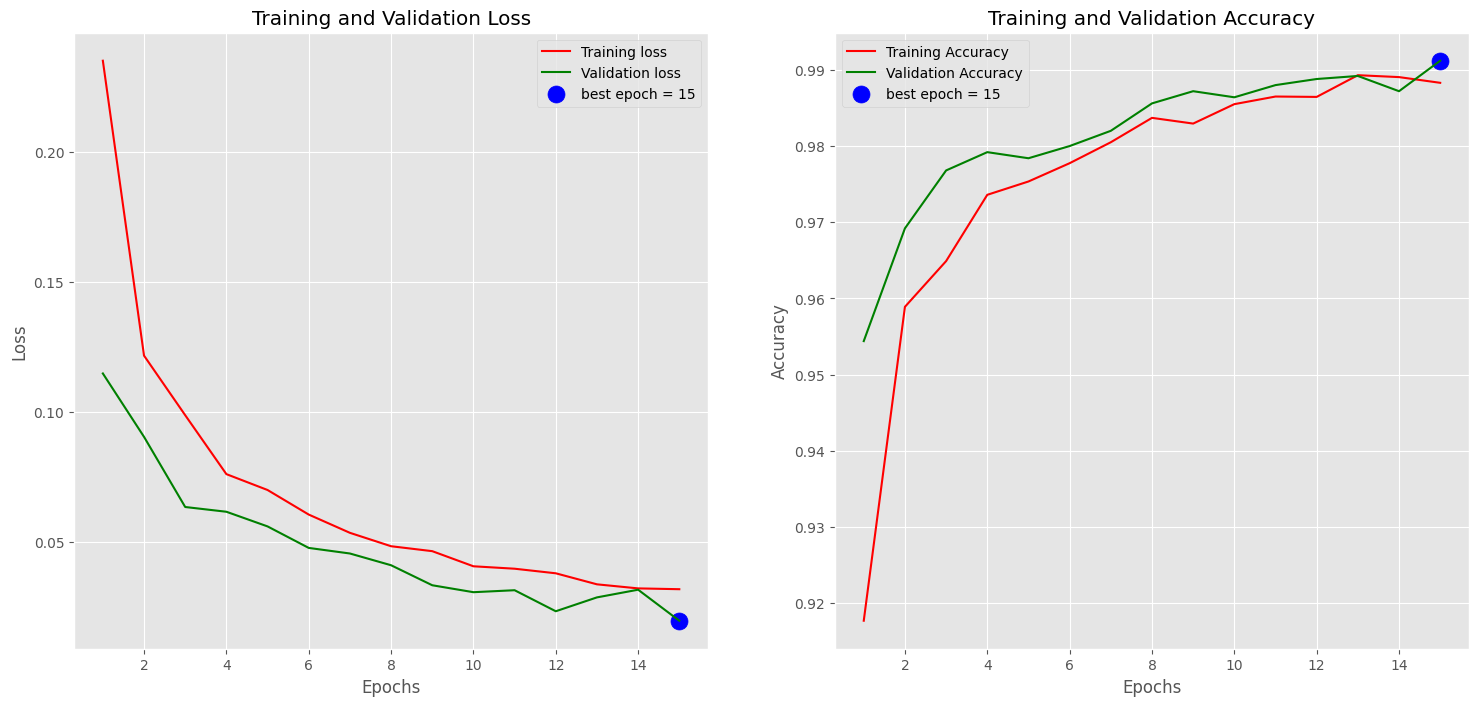

In [ ]:
plot_history(history_1)

In [ ]:
y_pred_1 = get_predictions(model_1, test_gen)

40/40 [==============================] - 11s 249ms/step


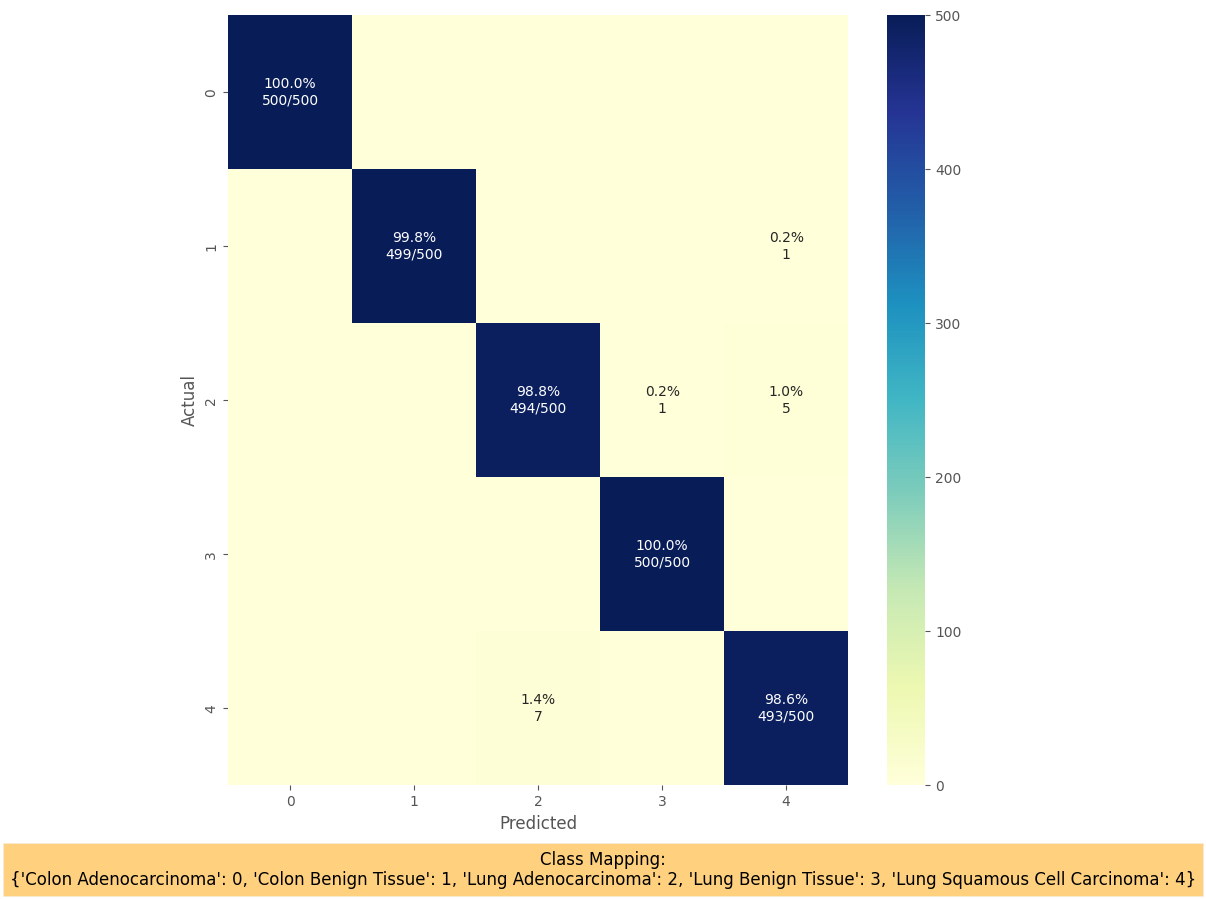

In [ ]:
plot_cm(test_gen.classes, y_pred_1)

### 4.2. EfficientNetV2B1

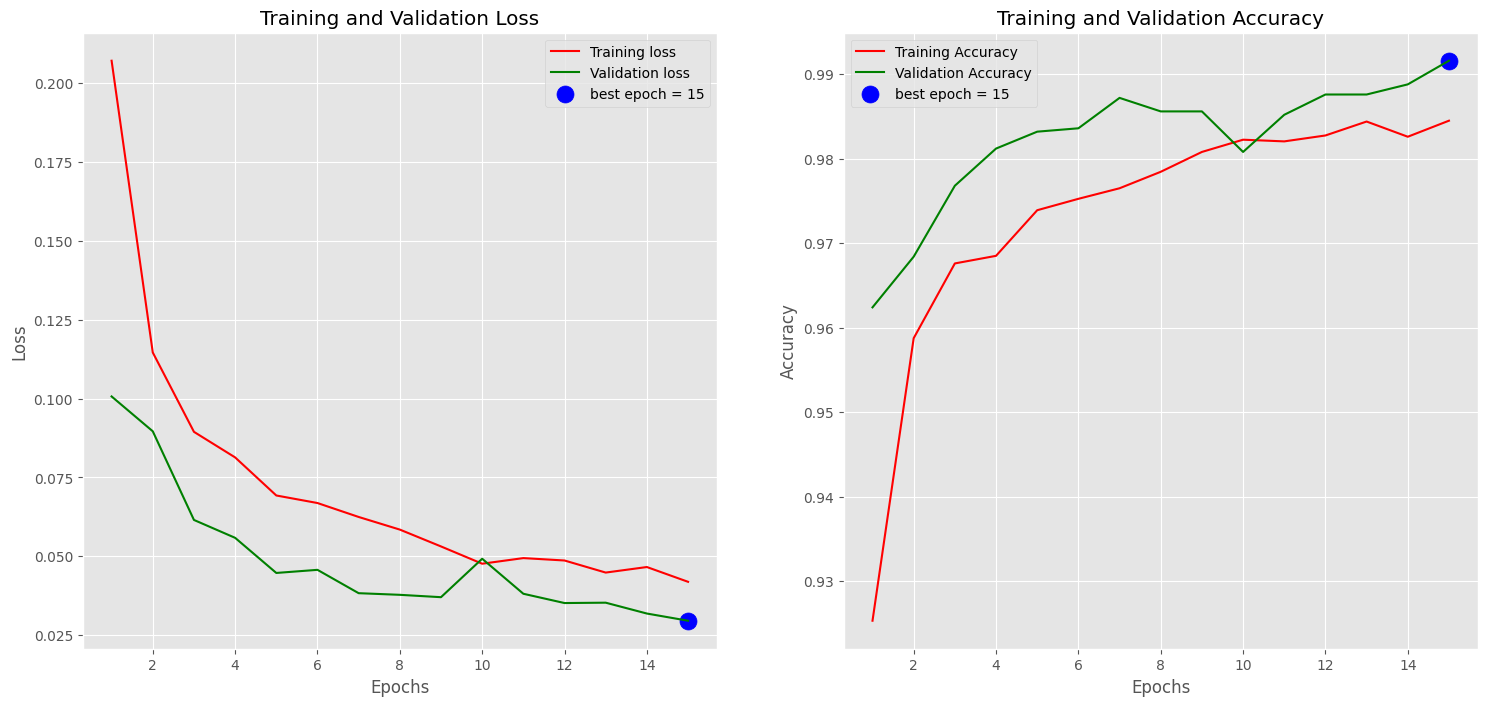

In [ ]:
plot_history(history_2)

In [ ]:
y_pred_2 = get_predictions(model_2, test_gen)

40/40 [==============================] - 12s 255ms/step


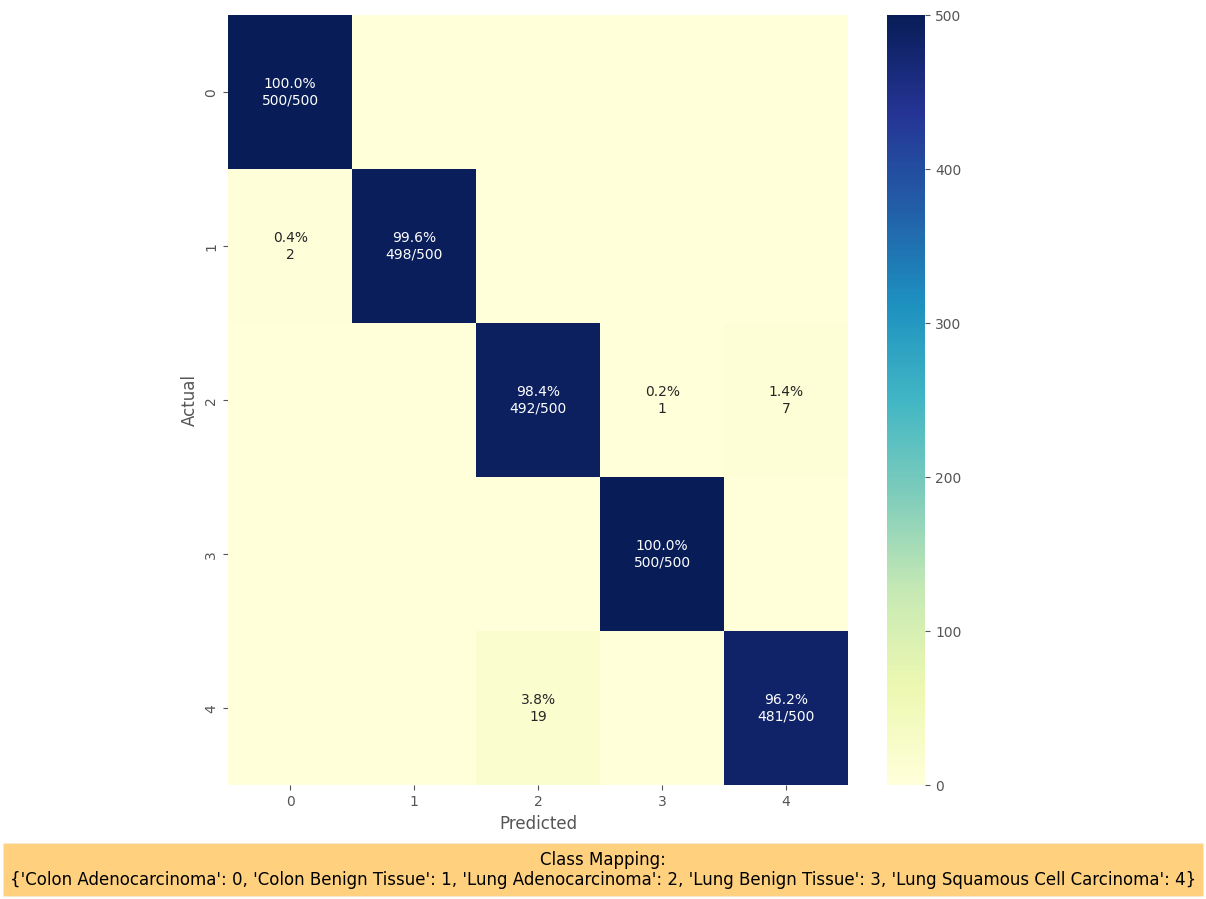

In [ ]:
plot_cm(test_gen.classes, y_pred_2)

### 4.3. ConvNeXtXLarge

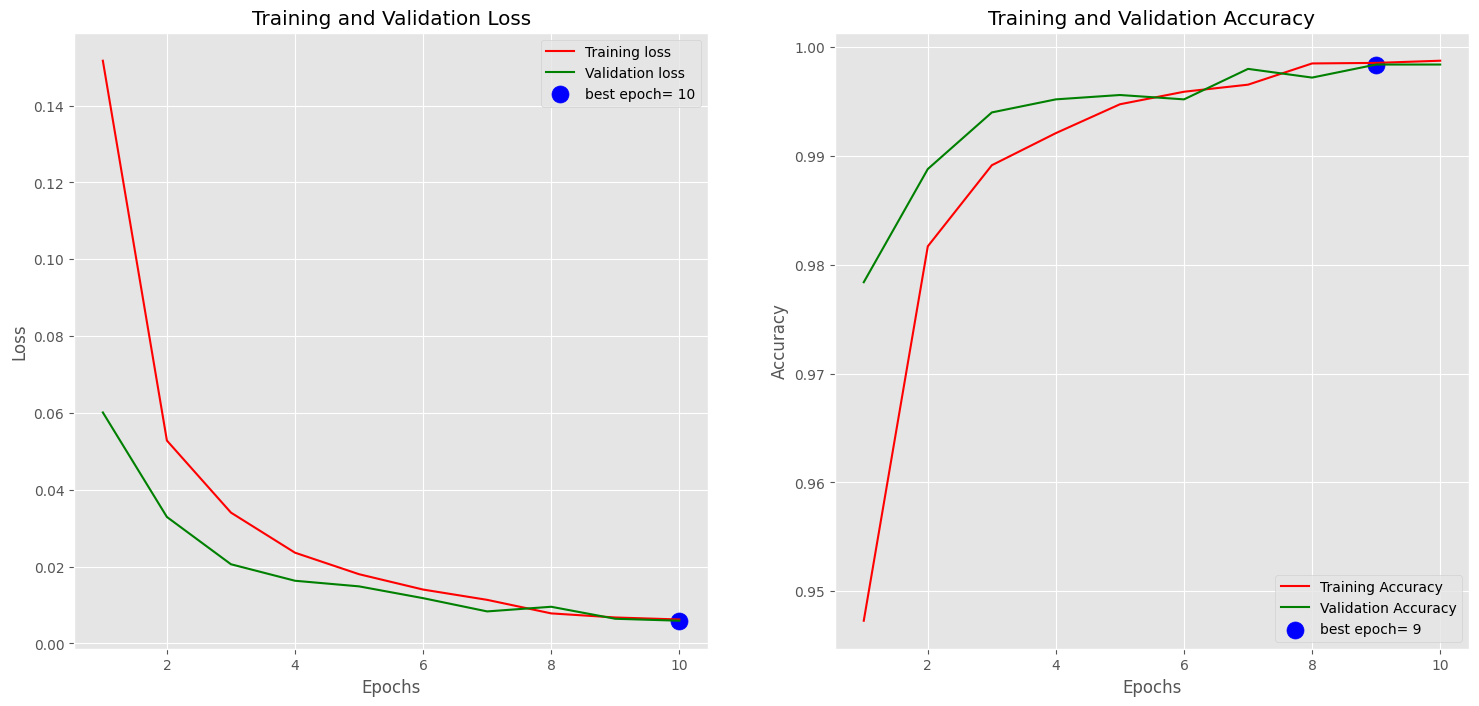

In [ ]:
plot_history(history_3)

In [ ]:
y_pred_3 = get_predictions(model_3, test_gen)

40/40 [==============================] - 24s 592ms/step


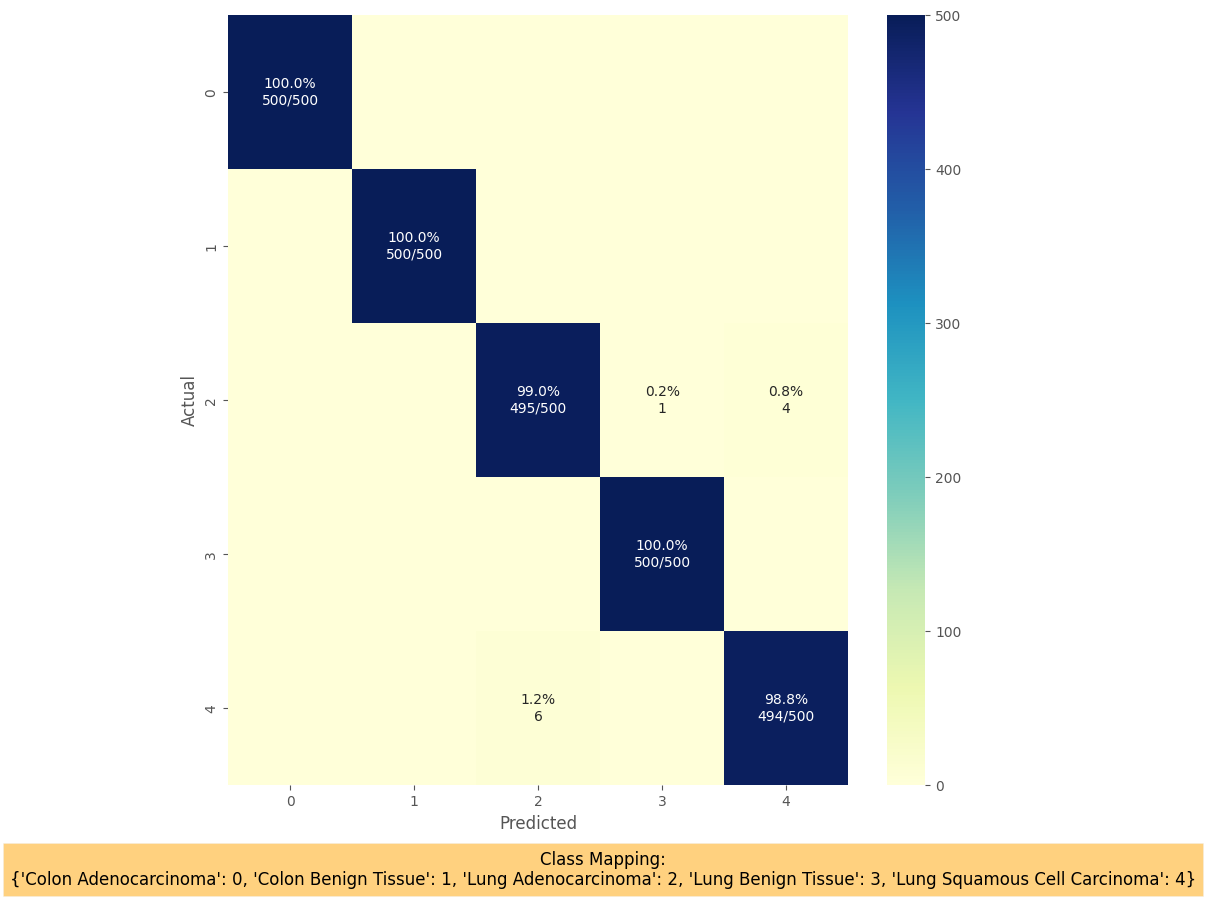

In [ ]:
plot_cm(test_gen.classes, y_pred_3)

### 4.4. Comparision

In [ ]:
results = {}
results['EfficientNetB0'] = report(test_gen.classes, y_pred_1)
results['EfficientNetV2B1'] = report(test_gen.classes, y_pred_2)
results['ConvNeXtXLarge'] = report(test_gen.classes, y_pred_3)
comparision = pd.DataFrame(results).T
display(comparision)

,Accuracy,Precision,Recall,F1-Score
EfficientNetB0,99.44,99.44,99.44,99.44
EfficientNetV2B1,98.84,98.85,98.84,98.84
ConvNeXtXLarge,99.56,99.56,99.56,99.56


## 5. Show Mispredicted Samples

### Helper Functions

In [ ]:
# show midpredicted images
def display_mispredicted(test_gen, y_pred):
  g_dict = test_gen.class_indices # defines dictionary {'class': index}
  classes = list(g_dict.keys()) # defines list of dictionary's kays (classes), classes names : string

  mispredicted = []
  label = []
  actual = []
  for i in range(len(y_pred)):
    if y_pred[i] != test_gen.classes[i]:
      mispredicted.append(test_gen.filenames[i])
      label.append(classes[test_gen.classes[i]])
      actual.append(classes[y_pred[i]])

  # print mispredicted images
  plt.figure(figsize= (16, 16))
  for i in range(len(mispredicted)):
      plt.subplot(math.ceil(len(mispredicted/4)), 4 , i + 1)
      image = plt.imread(mispredicted[i])
      plt.imshow(image)
      class_name = label[i]   # get predicted class of image
      actual_name = actual[i]   # get actual class of image
      plt.title(f'Predicted: {class_name}\n Actual: {actual_name}', color = 'blue', fontsize = 11)
      plt.axis('off')
  plt.show()

### 5.1. EfficientNetB0

In [ ]:
display_mispredicted(test_gen, y_pred_1)

### 5.2. EfficientNetV2B1

In [ ]:
display_mispredicted(test_gen, y_pred_2)

### 5.3. ConvNeXtXLarge

In [ ]:
display_mispredicted(test_gen, y_pred_3)